# TL;DR

This notebook:
* take a row index of the Poland 10km square shapefile as AOI to download a unique satellite tile for the gowing season of 2018 from 2018-05-01 (start_date) to 2018-10-31 (stop_date).
* Create an RGB image from one image of one date and run the "segment-anything" on it to get a "masks" list of all segments.
* Clean the masks to remove almost duplicates and too large areas
* Save the mask as a unique boolean mask without any overlapp in a shapefile which can be used for labelling.


## Run me

* In cell "Input needed: select an AOI" set variable "rowid" as any of the suggested Index for the Aoi. 
* Run Part 0 Installation and Initialization
* Restart Runtime
* Run all or you can also run cell by cell.

WARNING: it will take a while so be partient.

## WARNINGS

Files which will be overwritten:
* global_config.py
* masks.npy
* rgb_da_numpy_converted.png

Save your file first before run this notebook if you would like to keep them.

Hard coded:

Be aware that for now the location of the config file is hard coded:
'/content/drive/MyDrive/omdena-poland/task-1-dataset/global_config.py'

It can be improved later.


## Input needed: select an AOI

In [1]:
# select an AOI from a row index of the Poland 10km square shapefile
# Opole - Index [1609]
# Holy Cross - Index [3169, 3109]
# demo original [177]

rowid = 177

## Ouput: Shapefile of unique segmented polygons without overlapps

Output saved to: shp_dir/***tileId***_code_demo_clustering_x***coordinates***_y***coordinates***_step***chunksize***.shp

# Part 0: Installation and Initialization

### Mount Google Drive

Where data is stored and loaded.

In [2]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Import packages

First, check the contents of the current working directory to make sure the python files with the functions and global parameters are accessible. Then, load import the fields_functions.py file. The config parameters are stored in the global_config.py, imported at the top of the fields_functions.py along with all the packages necessary for processing. 

In [3]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [4]:
!conda --version

conda 23.3.1


In [5]:
!conda install gdal

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done

# All requested packages already installed.



In [6]:
# Update pip
!python -m pip install -U pip
# Install scikit-image
!python -m pip install -U scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_image-0.20.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.2 MB)
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.3
    Uninstalling scikit-image-0.19.3:
      Successfully uninstalled scikit-image-0.19.3


In [7]:
!pip install -r /content/drive/MyDrive/omdena-poland/task-1-dataset/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_image-0.19.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.9 MB)
  Attempting uninstall: scikit_image
    Found existing installation: scikit-image 0.20.0
    Uninstalling scikit-image-0.20.0:
      Successfully uninstalled scikit-image-0.20.0


In [8]:
import os
from glob import glob
from pprint import pprint
%matplotlib inline

cwd = os.getcwd()
print(cwd)

py_files = glob('/content/drive/MyDrive/omdena-poland/task-1-dataset/*.py')
print(py_files)

/content
['/content/drive/MyDrive/omdena-poland/task-1-dataset/fields_functions.py', '/content/drive/MyDrive/omdena-poland/task-1-dataset/global_config.py']


In [9]:
import sys
sys.path.append('/content/drive/MyDrive/omdena-poland/task-1-dataset/')

In [10]:
### Import fields functions
from fields_functions import *

### Packages for some plotting to view outputs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

Original global_config.py loaded.


# Introduction: Field Mapping Code: Clustering Approach Demonstration Notebook

This notebook walks through the different processing steps necessary to load Sentinel-2 data (from raw zipped .SAFE files or from a prepared sample dataset) and analyze the imagery through two workflows: Clustering and Thresholding. The core functions are stored in the fields_functions.py file, which references a file with global parameters, the global_config.py file, that stores parameters in a dictionary. Refer to that file to see what each parameter controls. Changing parameters can be done interactively in this notebook by reassigning new values to the parameter, such as: `config['prep_file_dir'] = 'path/to/directory/with/sentinel/tiles/'` 

Since there are multiple ways to load and process data, this notebook should not be run sequentially in full. The first step is loading the data. This can be done by using the `prep_data()` function to load data from a directory of zipped .SAFE Sentinel-2 L2A tiles. Since these tiles are large (about 1 GB per tile), the data is not directly available with the code. In order to enable testing of the analysis code, we have provided a sample dataset as part of thie repo. To load that, run the cell under the "Load Sample Data" heading.

NOTE: In addition to the text description, most of the code is commented for clarity.

# Part 1: Download satellite tile in the Aoi

A satellite tile is directly downloaded from the Area of interest (Aoi) as defined by a shapefile file of Poland cut in 10km squares. One of those squares need to be defined in advance by the row id of that shapefile to select a Aoi.

## Connect to the Copernicus Hub API

We will not use the Graphical User Interface from the Copernicus Open Access Hub as we want something fully automated, so we will use the API instead.

We will use the SentinelAPI: https://sentinelsat.readthedocs.io/en/latest/api_overview.html

In [11]:
#Enter default username and password

username = 'ludiusvox'
password = 'Gmoney300@'

config["username"] = username
config["password"] = password

api = SentinelAPI(username,password, "https://scihub.copernicus.eu/dhus")

### Changing global parameters

Let's take a look at the config parameters. The prefix for each parameter refers to the step in the processing workflow that corresponds with the parameters. For more detail about what each parameter controls, refer to the global_config.py file.

WARNING: it will not change the variable in the global_config.py file, only in the local "config" dictionnary.
It is needed to save those new paramters in the global_config.py before running any functions and modules in the fields_functions file, otherwise the default variables will be applied. This will be done when all new parameters are updated later in the notebook.

In [12]:
### We can change a parameter in the config dictionary by assigning it directly as so:
## WARNING: it will not change the variable in the global_config.py file, only in the local "config" dictionnary

# current paramters (will be changed automatically accroding to AOI later)
print("current x coordinate pixel start point for the tile subset:",config['prep_x_start']) # default 7500
print("current y coordinate pixel start point for the tile subset:",config['prep_y_start']) # default 7500

## Note: 500 pixels corresponds to 5km (resolution 10m per pixel)
config['prep_base_chunk'] = 500 # default 500
config['prep_manual_subset'] = True # force the subset to de defined manually

# selection of cloud coverage 
# NOTE: with a too low coverage (below 30) several harvest month images maybe be missing
prep_cloud_coverage_thresh = 30
config["prep_cloud_coverage_thresh"] = prep_cloud_coverage_thresh

print(config)

current x coordinate pixel start point for the tile subset: 7500
current y coordinate pixel start point for the tile subset: 7500
{'prep_file_dir': '/content/drive/MyDrive/omdena-poland/data', 'prep_tile_id': 'UEB', 'prep_base_chunk': 500, 'prep_time_chunk': 'auto', 'prep_remove_overlap': False, 'prep_manual_subset': True, 'prep_x_start': 7500, 'prep_y_start': 7500, 'prep_step': 500, 'prep_cloud_coverage_thresh': 30, 'prep_load_cloud_mask': True, 'prep_apply_cloud_mask': True, 'prep_cloud_mask_thresh': 70, 'prep_clip_outliers': True, 'prep_clip_percentile': 1, 'prep_normalize_bands': True, 'username': 'ludiusvox', 'password': 'Gmoney300@', 'preproc_out_dir': '/content/drive/MyDrive/omdena-poland/preproc', 'preproc_outfile_prefix': 'fields_preproc_demo_', 'preproc_sample_pct': 0.05, 'preproc_n_clusters': 15, 'preproc_cluster_tile': True, 'kmeans_n_clusters': 15, 'kmeans_model_out_dir': 'kmeans_model_dir/', 'kmeans_8var_clusters': True, 'kmeans_std_thresh': 0.2, 'kmeans_min_thresh': 0, '

### Loading data

The prep_data() function expects the `'prep_data_dir'` parameter in the config dictionary to have zipped Sentinel-2 L2A tiles. L2A tiles have been preprocessed to estimate bottom of atmosphere pixel values, correcting for atmospheric aerosols. The metadata for L1C data is apparently structured differently and does not work with the GDAL function to read the tile info.

The sample data comes in four versions for an area in Poland from a tile in the Aoi during the 2018 groing season: 500x500 pixels with and without cloud mask applied.

In our case for Poland, we will use directly zipped Sentinel-2 L2A tiles and the prep_data() module right after.

### Download L2A tiles

Sentinel images (aka data cubes) are called tiles and can be downloaded directly from the Copernicus Hub. The only thing which is needed is a shapefile of Area of Interest (aoi) to find the corresponding tile. In our case, we are interested in the full country of Poland which is our aoi. Luckily a shapefile for Poland can be found here: https://www.eea.europa.eu/data-and-maps/data/eea-reference-grids-2/gis-files/poland-shapefile

For our purpose, we will use the shapefile where the Poland area is devided in 10km squares area as illustrated below:

![pl_10km](pl_10km.png)

It is not perfect and we may need to remove squares which are 100% sea and which do not belong to Poland but the neigbhour countries.

In this demo, we will work only with one random selected square from this grid. As we do not know which squares are land or sea, we will first visualize the random selected square first. If it is land, we will use a seed to fix it for the demo, if it is sea we run the random selection again until we find land.

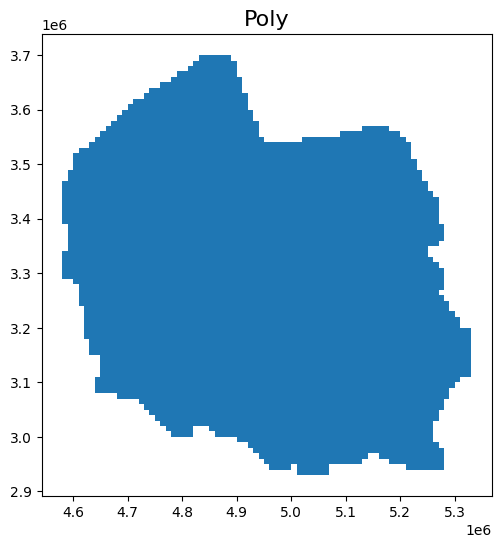

In [13]:
# Plot the shapefile
poly = gpd.read_file("/content/drive/MyDrive/omdena-poland/task-1-dataset/pl_10km.shp") # previously "POLYGON.shp"
fig, ax = plt.subplots(figsize=(6, 6))

poly.plot(ax=ax)

ax.set_title("Poly",
             fontsize=16)
plt.show()

In [14]:
# Load shape file
shapefile_all = gpd.read_file("/content/drive/MyDrive/omdena-poland/task-1-dataset/pl_10km.shp")
# Explore:
print(shapefile_all.head())
print(shapefile_all.crs)

       CELLCODE  EOFORIGIN  NOFORIGIN  \
0  10kmE458N329    4580000    3290000   
1  10kmE458N330    4580000    3300000   
2  10kmE458N331    4580000    3310000   
3  10kmE458N332    4580000    3320000   
4  10kmE458N333    4580000    3330000   

                                            geometry  
0  POLYGON ((4580000.000 3290000.000, 4580000.000...  
1  POLYGON ((4580000.000 3300000.000, 4580000.000...  
2  POLYGON ((4580000.000 3310000.000, 4580000.000...  
3  POLYGON ((4580000.000 3320000.000, 4580000.000...  
4  POLYGON ((4580000.000 3330000.000, 4580000.000...  
epsg:3035


The coordinate system is epsg:3035 and will need to be converted it to epsg:4326 for the SentinelAPI call. We also need to convert the shapefile to GeoJSON.

In [15]:
# change CRS to epsg 4326 - for API call and visualization with folium
shapefile_all_transformed = shapefile_all.to_crs(epsg=4326)
print(shapefile_all_transformed.head())
print(shapefile_all_transformed.crs)

       CELLCODE  EOFORIGIN  NOFORIGIN  \
0  10kmE458N329    4580000    3290000   
1  10kmE458N330    4580000    3300000   
2  10kmE458N331    4580000    3310000   
3  10kmE458N332    4580000    3320000   
4  10kmE458N333    4580000    3330000   

                                            geometry  
0  POLYGON ((13.82950 52.65766, 13.83735 52.74738...  
1  POLYGON ((13.83735 52.74738, 13.84523 52.83710...  
2  POLYGON ((13.84523 52.83710, 13.85316 52.92682...  
3  POLYGON ((13.85316 52.92682, 13.86112 53.01653...  
4  POLYGON ((13.86112 53.01653, 13.86913 53.10625...  
EPSG:4326


In [16]:
# transform the polygons coordinates to the coordinate system of the satellite tile image
shapefile_all_transformed_tile = shapefile_all.to_crs(epsg=32633)

## Select one polygon from the aoi.ipynb notebook

In [18]:
# select a random square for demo (I ran it twice and found a land square aoi so I fixed the seed for the demo)
# Opole - Index [1609]
# Holy Cross - Index [3169, 3109]
# demo original [177]
#rowid = 177

# If a rowid was not assigned at the beginning, assign a value per default
try: rowid
except NameError: rowid = 177

shapefile_original_coord = shapefile_all_transformed_tile.iloc[[rowid]]
shapefile = shapefile_all_transformed.iloc[[rowid]]

# Save selected AOI as shapefile for future use
prefix_file = 'aoi'
shapefile_path = config["prep_file_dir"]
shapefile_original_coord.to_file(shapefile_path+'/'+prefix_file+'_32633_shapefile.shp')
shapefile.to_file(shapefile_path+'/'+prefix_file+'_4326_shapefile.shp')

# Explore:
print(shapefile.head())
print(shapefile.crs)

         CELLCODE  EOFORIGIN  NOFORIGIN  \
177  10kmE464N329    4640000    3290000   

                                              geometry  
177  POLYGON ((14.71455 52.62600, 14.72420 52.71565...  
EPSG:4326


In [19]:
# To select the polygon in the tile later, we need the origin top-left corner of the polygon
# top-left corner coordinates of the shapefile 10km box
top_left_corner_poly_point_x, top_left_corner_poly_point_y = list(shapefile_original_coord.iloc[0,:]['geometry'].exterior.coords)[1]
# Set the origin top-ledft corner of the polygon as the x_start and y_start of our future subset of the tile
config['prep_x_start'] = top_left_corner_poly_point_x
config['prep_y_start'] =  top_left_corner_poly_point_y
print(top_left_corner_poly_point_x,top_left_corner_poly_point_y)

In [23]:
# Convert shapefile to GeoJSON as this is the format needed for the api
shapefile.to_file('POLYGON_POL_converted.geojson', driver='GeoJSON')

In [24]:
# Define the path to your AOI - Must be a Geojson shapefile
footprint = geojson_to_wkt(read_geojson("POLYGON_POL_converted.geojson"))
print(footprint)

GEOMETRYCOLLECTION(POLYGON((14.7146 52.6260,14.7242 52.7156,14.8719 52.7097,14.8619 52.6201,14.7146 52.6260)))


Let's plot the aoi with folium, we need first to give the longitude and latitude where the map should be centered to show our square of interest. We will take the top_left_corner coordinate of the aoi:

In [25]:
# Interactive visualization of polygon using the library folium
top_left_corner_poly_point_x_mercator, top_left_corner_poly_point_y_mercator = list(shapefile.iloc[0,:]['geometry'].exterior.coords)[1]
long, lat = top_left_corner_poly_point_x_mercator, top_left_corner_poly_point_y_mercator  # about (14,53) for Poland
m = folium.Map([lat, long], zoom_start=11)
boundary = gpd.read_file(r'POLYGON_POL_converted.geojson')
folium.GeoJson(boundary).add_to(m)
m

In [26]:
print("Cloud coverage selected: ", config["prep_cloud_coverage_thresh"])

Cloud coverage selected:  30


In [27]:
# Define the sentinel products we need
# Not too much data to start as we will download it locally and those images are massive in size (will take disk space and time to download)
# Here we will be looking with a Descending orbit direction from May to October 2022 (harvest months) Sentinel-2 Hyperspectral (Level-2A) with any cloud coverage for now.
start_date = '20180501'
stop_date = '20181031'
products = api.query(footprint,
                     date = (start_date,stop_date),
                     platformname='Sentinel-2',
                     processinglevel = 'Level-2A',
                     orbitdirection='DESCENDING',
                     cloudcoverpercentage=(0, prep_cloud_coverage_thresh))
# Download all products 
gdf = api.to_geodataframe(products)
print(gdf.shape)
gdf.head(3)

(18, 35)


,title,link,link_alternative,link_icon,summary,ondemand,ingestiondate,beginposition,endposition,orbitnumber,...,platformidentifier,orbitdirection,platformserialidentifier,processingbaseline,processinglevel,producttype,platformname,size,uuid,geometry
22f24f47-4dad-4fc6-957f-6e7f73c19aca,S2B_MSIL2A_20181021T101039_N0209_R022_T33UVU_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2018-10-21T10:10:39.024Z, Instrument: MS...",false,2018-10-21 22:02:38.684,2018-10-21 10:10:39.024,2018-10-21 10:10:39.024,8485,...,2017-013A,DESCENDING,Sentinel-2B,02.09,Level-2A,S2MSI2A,Sentinel-2,1.09 GB,22f24f47-4dad-4fc6-957f-6e7f73c19aca,"POLYGON ((13.50094 53.24020, 15.14628 53.24954..."
b9d3846a-a977-48b3-9893-845b4e6bf54e,S2A_MSIL2A_20181016T101021_N0209_R022_T33UVU_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2018-10-16T10:10:21.024Z, Instrument: MS...",false,2018-10-16 18:53:31.058,2018-10-16 10:10:21.024,2018-10-16 10:10:21.024,17322,...,2015-028A,DESCENDING,Sentinel-2A,02.09,Level-2A,S2MSI2A,Sentinel-2,1.09 GB,b9d3846a-a977-48b3-9893-845b4e6bf54e,"POLYGON ((13.50094 53.24020, 15.14628 53.24954..."
ed0d903d-c5ee-479f-99e0-6ab3e033b6b1,S2B_MSIL2A_20181011T101019_N0209_R022_T33UVU_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2018-10-11T10:10:19.024Z, Instrument: MS...",false,2018-10-11 17:28:54.458,2018-10-11 10:10:19.024,2018-10-11 10:10:19.024,8342,...,2017-013A,DESCENDING,Sentinel-2B,02.09,Level-2A,S2MSI2A,Sentinel-2,1.08 GB,ed0d903d-c5ee-479f-99e0-6ab3e033b6b1,"POLYGON ((13.50094 53.24020, 15.14628 53.24954..."


In [28]:
# Depending on the year the label of the columns change
# TODO: write a rootine which can handle all format automatically
#gdf.columns

In [29]:
start_datetime = pd.to_datetime(start_date ,format='%Y%m%d')
stop_datetime = pd.to_datetime(stop_date ,format='%Y%m%d')
nb_months = ((stop_datetime - start_datetime)/np.timedelta64(1, 'M')) # float
nb_months = int(nb_months)

In [30]:
# create some new columns wiht the tileidentifier (5 letter and number), the month and the date seperately
def extract_tileID(x):
    return x[5]
try:
  gdf['tileidentifier'] = gdf['title'].str.split("_").apply(extract_tileID)
  gdf['generationdateonly'] = pd.DatetimeIndex(gdf['beginposition']).date
  gdf['generationmonthonly'] = pd.DatetimeIndex(gdf['beginposition']).month

  # sort with less cloud coverage possible
  gdf_sorted = gdf.sort_values(['tileidentifier', 'beginposition', 'cloudcoverpercentage'], ascending=[True,True,True])
  #gdf_sorted.head(3)
except:
  print("Column Name doesn't exist.")
  gdf.columns

In [31]:
# check that we have the 6 months of interest for at least one tile
# If several tiles are available, take the tile with the most images
serie_uuid = gdf_sorted.groupby(['tileidentifier','generationmonthonly']).count()['uuid']
serie_uuid

tileidentifier  generationmonthonly
T33UVU          5                      5
                6                      1
                7                      3
                8                      4
                9                      1
                10                     4
Name: uuid, dtype: int64

In [32]:
list_unique_tilesidentifier = serie_uuid.index.get_level_values("tileidentifier").unique()
tileid_candidate = ''
mylist = []
for tileidentifier in list_unique_tilesidentifier:
  number_of_unique_month = len(serie_uuid[tileidentifier])
  tot_images = serie_uuid[tileidentifier].sum()
  mylist.append((number_of_unique_month,tot_images,tileidentifier))

sorted_list = sorted(mylist, key=lambda element: (element[1], element[2]),reverse=True)

tileid_candidate = sorted_list[0][2]
list_of_months = serie_uuid[tileid_candidate].index.to_list()
print(f"Selected tile candidate id {tileid_candidate} with {sorted_list[0][0]} months and a total of {sorted_list[0][1]} images data.")
if sorted_list[0][0] < nb_months:
  print(f"WARNING: got only {sorted_list[0][0]} months and not {nb_months} as selected by start_date {start_date} and stop_date {stop_date}")
config['prep_tile_id'] = tileid_candidate[-3:]

# In the case we have several tile in the product package, we take only the first one.
gdf_sorted_onetile = gdf_sorted[gdf_sorted['tileidentifier'] == tileid_candidate]
#gdf_sorted_onetile.head(3)

Selected tile candidate id T33UVU with 6 months and a total of 18 images data.


In [33]:

# WARNING ensure you have enough disk space for this demo. In my case it took 37.6 GB after a few tests.
# This will download N tiles of 6 months for tile id = T34UEB (see = 105) for the aoi of interest (not automated yet for checking if we have really the 6 months).
# Sometimes, the API is unable to download all the tiles, so we skip the failed download for now or trigger a Long Term Archive (LTA).
# Copernicus Open Access Hub no longer stores all products online for immediate retrieval. 
# Offline products can be requested from the Long Term Archive (LTA) and should become available within 24 hours
# Re-run the cell after 24 hours and the download in the archive will occur.
# Copernicus Open Access Hub’s quota currently permits users to request an offline product every 30 minutes.
from sentinelsat import LTAError
prep_file_dir = '/content/drive/MyDrive/omdena-poland/data'
config['prep_file_dir'] = prep_file_dir
Path(prep_file_dir).mkdir(exist_ok=True)
for item in gdf_sorted_onetile["uuid"]:
    corresponding_title = gdf_sorted_onetile.loc[[item]]['title']
    corresponding_title_zip = corresponding_title.values[0] + ".zip"
    print("corresponding_title_zip",corresponding_title_zip)
    path_file = os.path.join(prep_file_dir, corresponding_title_zip)
    if path.exists(path_file):
        print("file already exits", corresponding_title_zip)
    else:
        product_info = api.get_product_odata(item)
        is_online = api.is_online(item)

        if is_online:
            print(f'Product {item} is online. Starting download.')
            try:
                api.download(item, directory_path= prep_file_dir)
            except:
                print(item, "issue during download. Skip.")
                pass
        else:
            print(f'Product {item} is not online. Triggered Archive Retrieval. Info: Offline products retrieval quota 20 max per 12H.')
            try:
                api.trigger_offline_retrieval(item)
            except LTAError:
                print(item, "retrieval quota 20 max per 12H reached. Skip.")
                pass
            except:
                print(item, "issue during trigger_offline_retrieval call. Skip.")
                pass

corresponding_title_zip S2B_MSIL2A_20180504T101029_N0207_R022_T33UVU_20180504T122043.zip
file already exits S2B_MSIL2A_20180504T101029_N0207_R022_T33UVU_20180504T122043.zip
corresponding_title_zip S2A_MSIL2A_20180509T101031_N0207_R022_T33UVU_20180509T135043.zip
file already exits S2A_MSIL2A_20180509T101031_N0207_R022_T33UVU_20180509T135043.zip
corresponding_title_zip S2B_MSIL2A_20180514T101029_N0207_R022_T33UVU_20180514T122533.zip
file already exits S2B_MSIL2A_20180514T101029_N0207_R022_T33UVU_20180514T122533.zip
corresponding_title_zip S2B_MSIL2A_20180524T101019_N0208_R022_T33UVU_20180524T145442.zip
file already exits S2B_MSIL2A_20180524T101019_N0208_R022_T33UVU_20180524T145442.zip
corresponding_title_zip S2A_MSIL2A_20180529T101031_N0208_R022_T33UVU_20180529T112942.zip
file already exits S2A_MSIL2A_20180529T101031_N0208_R022_T33UVU_20180529T112942.zip
corresponding_title_zip S2A_MSIL2A_20180608T101021_N0208_R022_T33UVU_20180608T131739.zip
file already exits S2A_MSIL2A_20180608T101021_

# Part 2: Loading sample data
Here, we will load the prepared sample data for a 500x500 pixel area by reading the Copernicus zip folder directly into an xarray dataset. This is the same as the prep_data() output but for a smaller spatial area. When we read in the data with `xr.open_dataset()` be sure to include the `chunks` argument to coerce the data into dask arrays, which enable parallel processing during the analysis steps. Here, we use the `'auto'` argument to allow xarray to automatically assign an appropriate chunk size to each of the three dimensions: x, y, and time.

In [34]:
## WARNING: this will overwrite the config file with all the new variables we updated above
# Need to save it for validation and use
with open('/content/drive/MyDrive/omdena-poland/task-1-dataset/global_config.py', 'w') as convert_file:
     convert_file.write(json.dumps(config))
del config

In [35]:
# force to reload global_config inside all the modules and functions
from fields_functions import * 
#from global_config import *
print("Data type after reconstruction : ", type(config))
print(config)

Data type after reconstruction :  <class 'dict'>
{'prep_file_dir': '/content/drive/MyDrive/omdena-poland/data', 'prep_tile_id': 'UVU', 'prep_base_chunk': 500, 'prep_time_chunk': 'auto', 'prep_remove_overlap': False, 'prep_manual_subset': True, 'prep_x_start': 481369.51266067114, 'prep_y_start': 5840674.968907499, 'prep_step': 500, 'prep_cloud_coverage_thresh': 30, 'prep_load_cloud_mask': True, 'prep_apply_cloud_mask': True, 'prep_cloud_mask_thresh': 70, 'prep_clip_outliers': True, 'prep_clip_percentile': 1, 'prep_normalize_bands': True, 'username': 'ludiusvox', 'password': 'Gmoney300@', 'preproc_out_dir': '/content/drive/MyDrive/omdena-poland/preproc', 'preproc_outfile_prefix': 'fields_preproc_demo_', 'preproc_sample_pct': 0.05, 'preproc_n_clusters': 15, 'preproc_cluster_tile': True, 'kmeans_n_clusters': 15, 'kmeans_model_out_dir': 'kmeans_model_dir/', 'kmeans_8var_clusters': True, 'kmeans_std_thresh': 0.2, 'kmeans_min_thresh': 0, 'kmeans_max_thresh': 0.3, 'kmeans_range_thresh': 0.7, '

In [36]:
### Loading data from a directory of zipped Sentinel-2 files
### Skip this step if you do not have a directory with Sentinel-2 tiles in it 
### Load the sample data in the cell below instead.
#from google.colab import files

ds_time_stack = prep_data()

Cloud Coverage Threshold: 30
passed cloud coverage: 2018 06 08 with 0.139558 pct | nodata pixel pct: 0.0
Manual subset: Shapefile coordinates detected.
passed cloud coverage: 2018 08 17 with 1.9525850000000002 pct | nodata pixel pct: 0.0
Manual subset: Shapefile coordinates detected.
passed cloud coverage: 2018 05 04 with 0.150072 pct | nodata pixel pct: 0.0
Manual subset: Shapefile coordinates detected.
passed cloud coverage: 2018 05 14 with 0.435845 pct | nodata pixel pct: 0.0
Manual subset: Shapefile coordinates detected.
passed cloud coverage: 2018 05 24 with 17.859347 pct | nodata pixel pct: 0.0
Manual subset: Shapefile coordinates detected.
passed cloud coverage: 2018 07 03 with 3.44252 pct | nodata pixel pct: 3e-06
Manual subset: Shapefile coordinates detected.
passed cloud coverage: 2018 07 23 with 3.356427 pct | nodata pixel pct: 0.000133
Manual subset: Shapefile coordinates detected.
passed cloud coverage: 2018 08 22 with 0.101692 pct | nodata pixel pct: 1.3e-05
Manual subset

In [37]:
# Create a shapefile of the tile, aoi and subset for visualization sanity check
shp_path ="/content/drive/MyDrive/omdena-poland/data/aoi_4326_shapefile.shp"
shp_path2 ="/content/drive/MyDrive/omdena-poland/data/subset_4326_shapefile.shp"
shp_path3 ="/content/drive/MyDrive/omdena-poland/data/tile_4326_shapefile.shp"
sf = gpd.read_file(shp_path)
sf2 = gpd.read_file(shp_path2)
sf3 = gpd.read_file(shp_path3)

joined = pd.concat([sf3.geometry, sf.geometry,sf2.geometry])
joineddf = gpd.GeoDataFrame(joined)
joineddf= joineddf.assign(Name=['tile', 'aoi','subset'])
joineddf.reset_index()
prefix_file = 'tile_aoi_subset'
shapefile_path = '/content/drive/MyDrive/omdena-poland/data/'
joineddf.to_file(shapefile_path+'/'+prefix_file+'_shapefile.shp')

'\nfor _, row in joineddf.iterrows():\n    # Convert the geometry to a shapely object\n    geom = shape(row["geometry"])\n    name = row[\'Name\']\n\n    coords = [(x, y) for x, y in geom.exterior.coords]\n\n    print(name)\n    print(coords)\n'

### Visualize one or several from the imagery

Let's take a look at the RGB band from one of the time steps in our raster stack. We named this object `ds_time_stack` because it is an xarray Dataset (ds) structure comprised of a stack of 4-band raster imagery across the time period of our study (May - October, 20XX). We can use some built-in xarray methods to select the time based on an index value in the time dimension `.isel(time=8)` and select the RGB band via the data variable name `.red` etc and then use the `.plot()` method to visualize the band via a matplotlib wrapper function.

Need to create a xarray with coordinates to convert into a RGB image to feed the segmentation algorithm:

(500, 500, 3)
<xarray.DataArray 'red' (y: 500, x: 500, band: 3)>
dask.array<transpose, shape=(500, 500, 3), dtype=int64, chunksize=(500, 500, 1), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 5.819e+06 5.819e+06 5.819e+06 ... 5.814e+06 5.814e+06
  * x        (x) float64 4.593e+05 4.593e+05 4.593e+05 ... 4.643e+05 4.643e+05
    time     datetime64[ns] 2018-08-09
  * band     (band) <U1 'r' 'g' 'b'


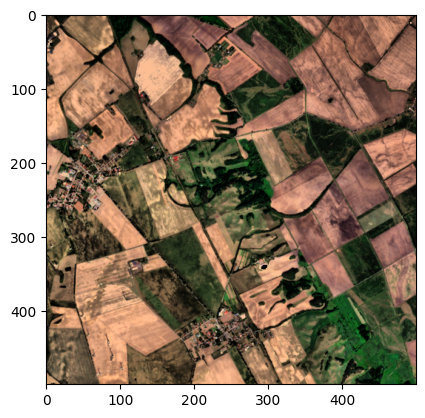

In [38]:
# Create RGB from ds_time_stack for one date

# select a month as an integer to select a date from (eg. 5 is May, 8 is August etc.)
# WARNING: needs to be a month between start_date and stop_date
month_selected = 8
# Select if you want the RGB image to get more sharpe or not
image_equalization = True

if month_selected in list_of_months:
  # take first image of the month selected
  xdate = ds_time_stack.sel(time=ds_time_stack.time.dt.month.isin([month_selected])).time[0]
  rgb_da = clip_nan_ufunc(xr.concat([ds_time_stack.red.sel(time=xdate),
                                   ds_time_stack.green.sel(time=xdate),
                                   ds_time_stack.blue.sel(time=xdate)], dim='band'), percentile=1)
else:
  import random
  date_index = random.randint(0,len(ds_time_stack.time)-1) # choose one random date only
  rgb_da = clip_nan_ufunc(xr.concat([ds_time_stack.red.isel(time=date_index),
                                    ds_time_stack.green.isel(time=date_index),
                                    ds_time_stack.blue.isel(time=date_index)], dim='band'), percentile=1)

rgb_da = rgb_da.assign_coords(band=['r','g','b'])

### Transpose to (y, x, band) 
rgb_da = rgb_da.transpose('y', 'x', 'band')
print(rgb_da.shape)
print(rgb_da)

# Visualization
if image_equalization:
  rgb_da_image = exposure.equalize_adapthist(rgb_da.values,clip_limit=0.01)
else:
  rgb_da_image = rgb_da
plt.imshow(rgb_da_image)
#plt.axis('off')
#plt.savefig("rgb_test.png", bbox_inches='tight', pad_inches = 0)

In [39]:
# Convert xarray to numpy and check the form
if isinstance(rgb_da_image, np.ndarray):
  rgb_da_numpy = rgb_da_image
else:
  rgb_da_numpy = rgb_da_image.to_numpy()

print(type(rgb_da_numpy))
print(rgb_da_numpy.shape)

<class 'numpy.ndarray'>
(500, 500, 3)


Need now to be converted to 0 to 255 for saving it as RGB:

In [40]:
# Is there nan values?
if np.isnan(np.sum(rgb_da_numpy)):
  new_rgb_da_numpy = np.nan_to_num(rgb_da_numpy) #remove NaN values
  #np.isnan(np.sum(new_rgb_da_numpy))
else:
  new_rgb_da_numpy = rgb_da_numpy

In [41]:
# Normalizing in the range 0 to 1.
rgb_da_numpy_norm = (new_rgb_da_numpy-np.min(new_rgb_da_numpy))/(np.max(new_rgb_da_numpy)-np.min(new_rgb_da_numpy))

#print(rgb_da_numpy_norm)

# Scaling from 0 to 255 for future images pixel values
rgb_da_numpy_norm*=255

#print(rgb_da_numpy_norm)

# convert to uint8 for image pixel value
rgb_da_numpy_converted = rgb_da_numpy_norm.astype(np.uint8)

print(type(rgb_da_numpy_converted))
print(rgb_da_numpy_converted.shape)
image = rgb_da_numpy_converted

<class 'numpy.ndarray'>
(500, 500, 3)


In [42]:
# Export the numpy array to a png
from PIL import Image as im

data = im.fromarray(rgb_da_numpy_converted)
#image_RGB_file_name = "rgb_da_numpy_converted_"+ds_time_stack.tile_id+".png"
#data.save('/content/drive/MyDrive/omdena-poland/data/'+image_RGB_file_name)
data.save('/content/drive/MyDrive/omdena-poland/data/rgb_da_numpy_converted.png')

In [43]:
# Visualization
#import cv2
#plt.figure()
#plt.imshow(image)
#plt.axis('off')
#plt.show()

In [44]:
# Read back the image
#import cv2
#image = cv2.imread('/content/drive/MyDrive/omdena-poland/data/'+image_RGB_file_name)
#image = cv2.imread('/content/drive/MyDrive/omdena-poland/data/rgb_da_numpy_converted.png')
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#print(type(image))
#print(image.shape)

Checked: kept dimensions (500, 500, 3). Good to go to the segmentation notebook or cells below.

# Part 3: "segment-anything" mask on an RGB image

Create a "segment-anything" mask on the RGB image and save it for future use.

Two methods:
1.   Run the cells below. If the 'cuda' is not available it will be a slow process.
2.   Open the "Shared_segment_seg.ipynb" notebook and run it. Due to a more
recent version of python it seems the 'cuda' is available.


### Setup and installation

In [45]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [46]:
!python --version

Python 3.10.10


In [47]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 624.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 78.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.6/532.6 kB 28.7 MB/s eta 0:00:00
  Created wheel for lit: filename=lit-15.0.7-py3-none-any.whl size=90003 sha256=c4b01f3b2942296c2d01ade5aec485dd771575e514d12c747b379d99c17b2d0b
  Stored in directory: /root/.cache/pip/wheels/bf/62/0d/012

In [48]:
using_colab = True

In [49]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    # sometimes GPU is not available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    #!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.0+cu118
Torchvision version: 0.15.1+cu118
CUDA is available: False
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-w0qxa_3b
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-w0qxa_3b
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 567662b0fd33ca4b022d94d3b8de896628cd32dd
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36610 sha256=ae231739bb296244babca0d117867ece6fdcd27bff250789794b6f0428d5becb
  Stored in directory: /tmp/pip-ephem-wheel-cache-s4ly9k8c/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built seg

In [56]:
# optional library for visualization
!pip install -q supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 13.8 MB/s eta 0:00:00


### Running Segment-Anything

In [50]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [51]:
#image_RGB_file_name = "rgb_da_numpy_converted_"+ds_time_stack.tile_id+".png"
#image = cv2.imread('/content/drive/MyDrive/omdena-poland/data/'+image_RGB_file_name)
image = cv2.imread('/content/drive/MyDrive/omdena-poland/data/rgb_da_numpy_converted.png')
print(type(image))
print(image.shape)

<class 'numpy.ndarray'>
(500, 500, 3)


In [52]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

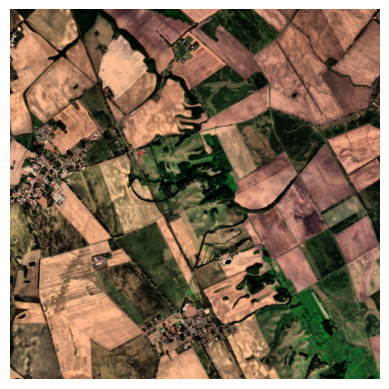

In [53]:
plt.figure()
plt.imshow(image)
plt.axis('off')
plt.show()

In [54]:
import sys
sys.path.append("")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = 'vit_h'
#device = 'cuda' #depending on availability (see cell which install pytorch)
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator = SamAutomaticMaskGenerator(sam)
print(f"You are running on {device}. It will take a while!")

You are running on cpu.


In [55]:
# take a while on 'cpu'
masks = mask_generator.generate(image)

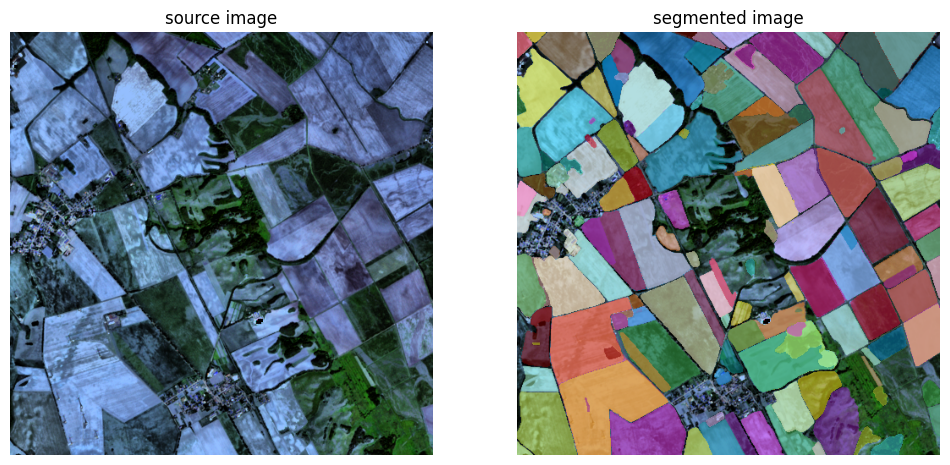

In [57]:
import supervision as sv
mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=masks)

annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)

sv.plot_images_grid(
    images=[image, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [58]:
# Export output masks. 
# WARNINGS: using pickle library, can create security issues.
#sam_mask_file_name = "mask_"+ds_time_stack.tile_id+".npy"
#np.save('/content/drive/MyDrive/omdena-poland/data/'+sam_mask_file_name,masks)
np.save('/content/drive/MyDrive/omdena-poland/data/masks.npy',masks)

# Part 4: Load the masks and extract one unique mask shapefile

Reload the masks list as the raw output of "segment-anything":

In [59]:
# image: rgb_da_numpy_converted.png was used for this mask
# corresponding array: rgb_da_numpy_converted
#sam_mask_file_name = "mask_"+ds_time_stack.tile_id+".npy"
#masks = np.load('/content/drive/MyDrive/omdena-poland/data/'+sam_mask_file_name, allow_pickle=True)
masks = np.load('/content/drive/MyDrive/omdena-poland/data/masks.npy', allow_pickle=True)

In [60]:
# masks is a list of dictionnaries
# look at the key of a random individual dictionary 
print(masks[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


## Masks exploration

In [61]:
# Create lists varaibles for histogram plotting
mask_stability_score = np.zeros(len(masks)) # stability score (quality metric of a mask, close to 1. is good)
mask_predicted_iou = np.zeros(len(masks)) # stability score (quality metric of a mask, close to 1. is good)
mask_area = np.zeros(len(masks)) # number of pixel in the mask segmentation
for i, mask in enumerate(sorted(masks, key=lambda x: x['area'], reverse=True)):
  mask_stability_score[i] = mask['stability_score']
  mask_predicted_iou[i] = mask['predicted_iou']
  mask_area[i] = mask['area']

(grid_height, grid_width) (12, 15)


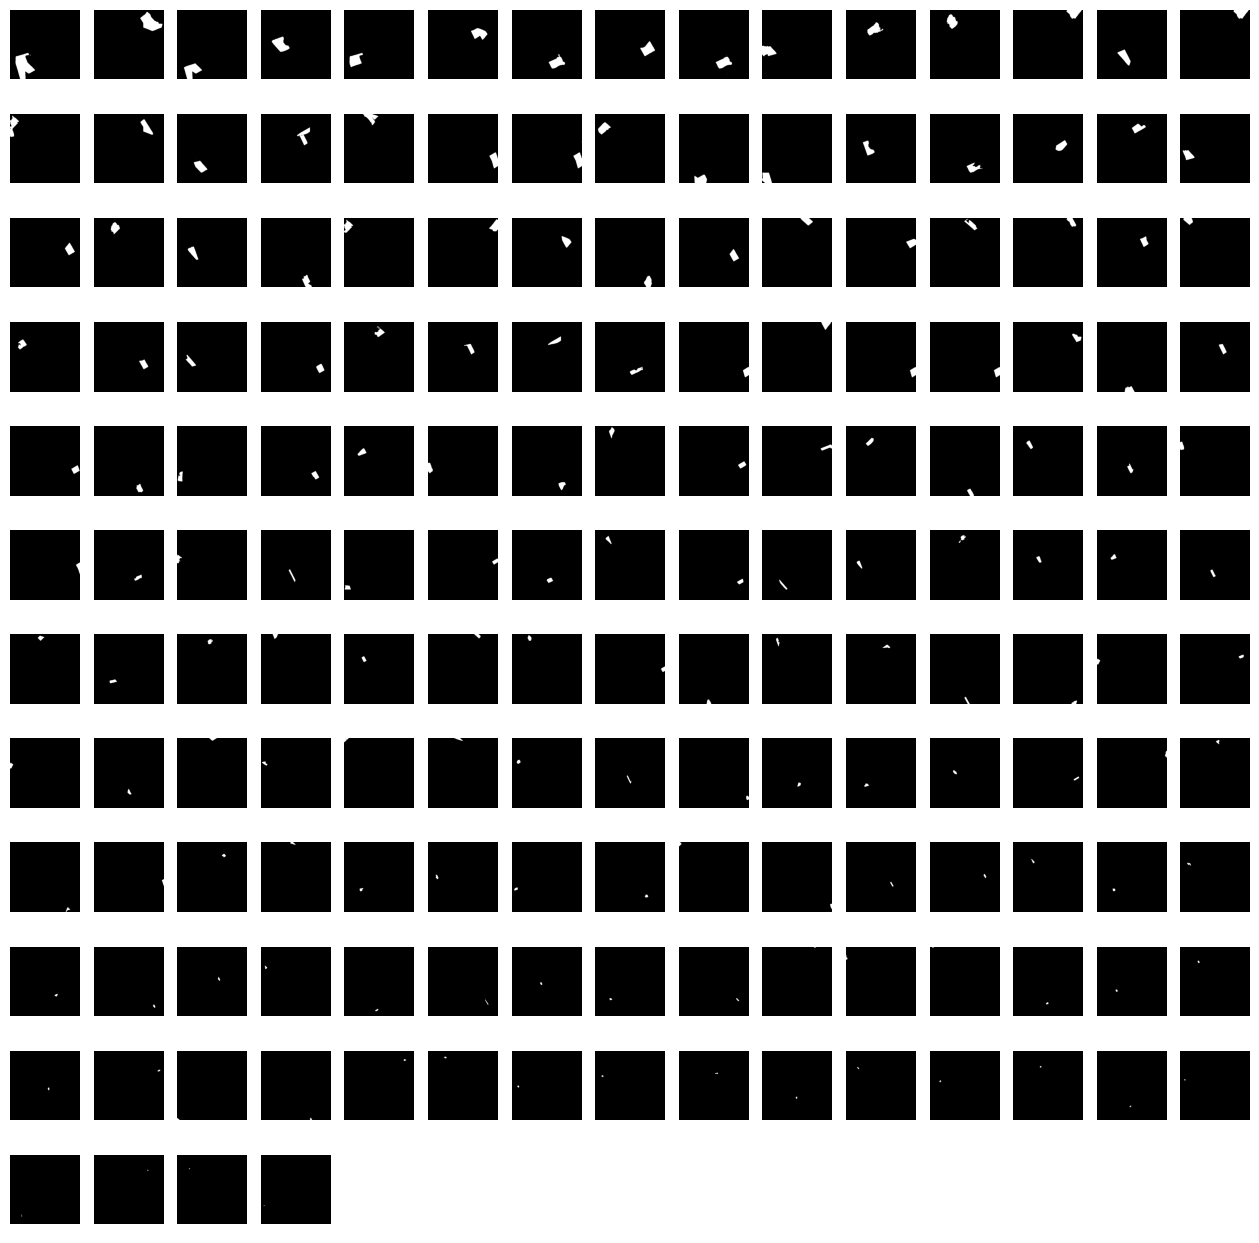

In [63]:
# Create a list of all the mask (extract from dictionnaries) for visualization
masks_all = [
    mask['segmentation']
    for mask
    in sorted(masks, key=lambda x: x['area'], reverse=True) 
]

# Initialize the grip for plotting
grid_width = 15
grid_height = len(masks)//grid_width
if (grid_height*grid_width) < len(masks): grid_height+=1
print("(grid_height, grid_width)",(grid_height, grid_width))

sv.plot_images_grid(
    images=masks_all,
    grid_size=(grid_height, grid_width),
    size=(16, 16)
)

Plot histograms for masks metrics:

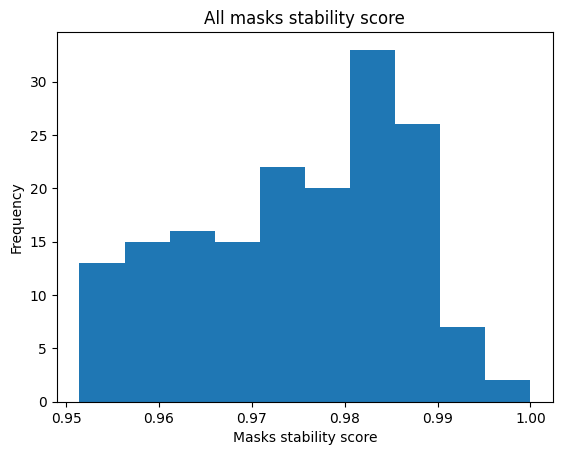

In [123]:
plt.hist(mask_stability_score);
plt.xlabel('Masks stability score')
plt.ylabel('Frequency')
plt.title('All masks stability score')
plt.show()

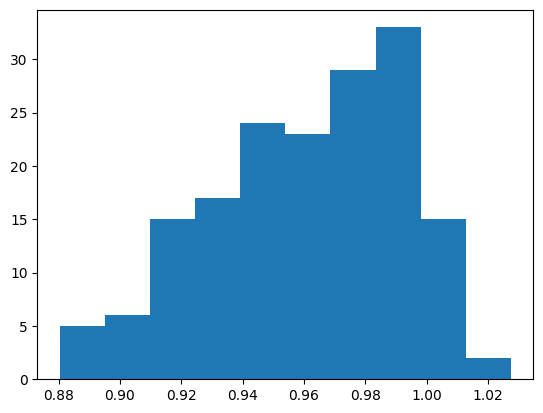

In [65]:
plt.hist(mask_predicted_iou);
plt.xlabel('Masks predicted Intersection over Union (iou) score')
plt.ylabel('Frequency')
plt.title('All masks predicted iou')
plt.show()

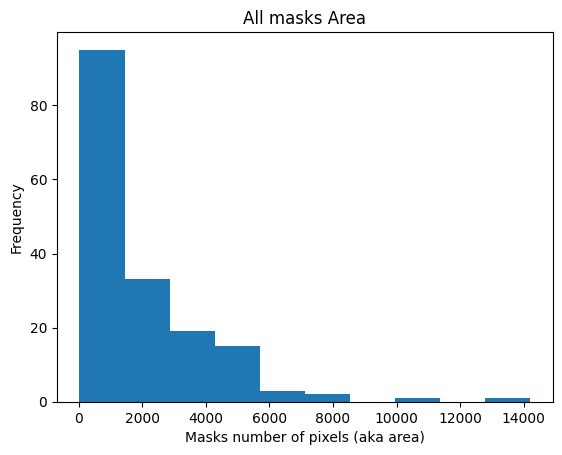

In [124]:
plt.hist(mask_area);
plt.xlabel('Masks number of pixels (aka area)')
plt.ylabel('Frequency')
plt.title('All masks Area')
plt.show()

In [67]:
# Look at the smallest area - not likely a field
np.sort(mask_area)[:10]

array([ 26.,  40.,  44.,  48.,  65.,  89., 101., 114., 116., 125.])

## Masks cleaning

### According to metrics
Remove masks which are:

*   Too small (criteria: below 5th percentile)
*   Too large (criteria: larger than 1/4 of the full image)

to be a field.

In [68]:
# Define max areas limit
area_max_limit = (image.shape[0]*image.shape[1])/4
area_max_limit

62500.0

In [69]:
# Remove any masks above max area
new_mask_area = mask_area[mask_area<area_max_limit]

In [70]:
print("Number of masks before (all masks):", len(mask_area))
print("Number of masks after:",len(new_mask_area))

169
169


In [71]:
# Define limits and Remove any masks below 5th percentile
p95, p5 = np.percentile(new_mask_area, [95, 5])
print("5th percentile:", p5)
print("95th percentile:", p95)
new_mask_area = new_mask_area[new_mask_area > p5]

119.60000000000001
5561.599999999999


In [72]:
print("Number of masks after:",len(new_mask_area))
#plt.hist(new_mask_area);

169
160


In [74]:
# More criteria to clean masks can be explore (like using the masks quality metrics)
masks_all = []
cnt = 0
for i, mask in enumerate(sorted(masks, key=lambda x: x['area'], reverse=True)):
  #if mask['predicted_iou'] > 0.95 and mask['area'] < area_max_limit and mask['area'] > p5:
  #if mask['predicted_iou'] > 0.90 and mask['area'] < area_max_limit:
  #if mask['stability_score'] > 0.95 and mask['predicted_iou'] > 0.95:
  if mask['area'] < area_max_limit and mask['area'] > p5:
    masks_all.append(mask['segmentation'])
    cnt+=1
print("Number of masks now:",len(masks_all))

### Removing similar masks

In the visualization, we see that some contiguous masks in the list are close to 99% similar (only a few pixels difference). Only the first of the pair will be preserved.

In [77]:
def percentage_overlap(mask1, mask2):
    """Calculate the percentage overlap of two numpy boolean masks"""
    overlap = np.sum(mask1 & mask2)
    total_pixels = np.sum(mask1 | mask2)
    return overlap / total_pixels * 100

[20, 55]


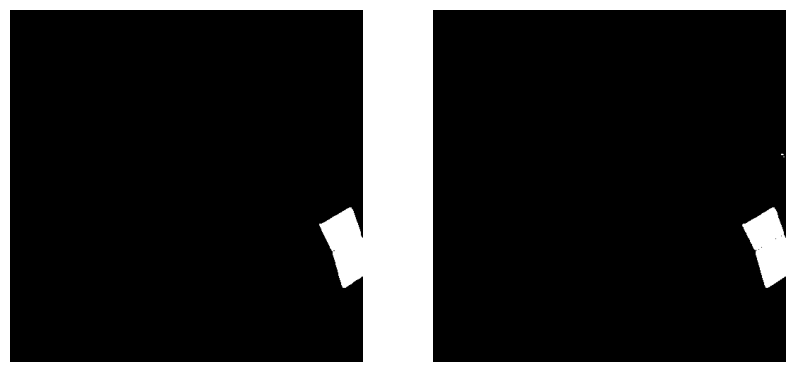

In [78]:
# Search for all the identical masks pairs and keep only the first one
idx_list = []
for i in range(1,len(masks_all)):
  pct = percentage_overlap(masks_all[i-1], masks_all[i])
  if pct > 0.0:
    idx_list.append(i-1)
print(idx_list)

# Illustration example of contiguous masks in the list that are almost identical
sv.plot_images_grid(
    images=masks_all[idx_list[0]:idx_list[0]+2],
    grid_size=(1, 2),
    size=(10, 10)
)

In [79]:
# Keep only the masks which are really different
masks_selection = [ele for idx, ele in enumerate(masks_all) if idx not in idx_list]
print("Number of masks now:",len(masks_selection))

158


Now all similar masks are removed.

## Create one unique boolean masks of the segmentation for future labelling

Need to create a 100% overlap free masks for labelling.

In [81]:
# 100% overlap free
# Create a 2D matrix from the list of masks
# Starting from the smallest to the largest areas
# Take only the 0% overlap masks
reversed_masks_selection = masks_selection[::-1]
unique_mask = reversed_masks_selection[0]
for i in range(1,len(masks_selection)):
  pct = percentage_overlap(unique_mask, reversed_masks_selection[i])
  if pct > 0.0:
    continue
  else:
    unique_mask = (reversed_masks_selection[i] | unique_mask)

In [82]:
# From float to integer
one_unique_mask_num = unique_mask.astype(int) 

In [83]:
# Convert into xarray to get the coordinates back from the original subset (rgb_da)
one_unique_mask_img_da = xr.DataArray(one_unique_mask_num,
                                dims=['y','x'],
                                coords={'x':rgb_da.coords['x'],
                                        'y':rgb_da.coords['y']})
one_unique_mask_img_da = one_unique_mask_img_da.chunk({'x': 'auto', 'y': 'auto'}).astype(int)

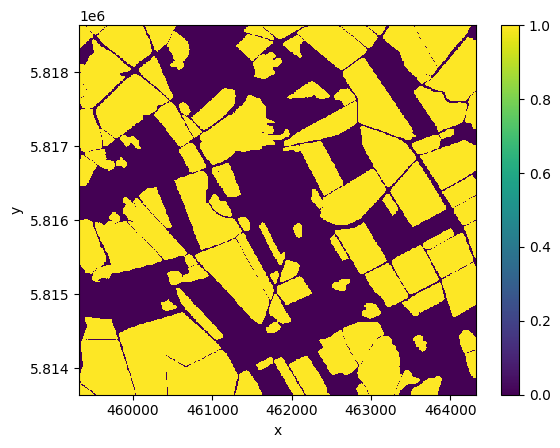

In [84]:
# Visualization 100% overlap free mask
# Segmented area in yellow
one_unique_mask_img_da.plot()

## Create background masks

To ensure that the background (no segmentation) is taken into account, a No-Segmentation mask is created as it is need to create the 'default' shapefile functions.

In [85]:
# Assign 300 as 'NaN' (aka no segmentation) in the orgininal 
# output from the 'segment-anything masks'
w, h = config['prep_base_chunk'],config['prep_base_chunk']
def show_anns(masks_list):
  img = np.full((w, h), 300) # same as nan
  for cluster, ann in enumerate(masks_list):
    m = ann # (500,500) mask bolean
    img = np.where(m > 0, cluster+1, img)
  return img

In [86]:
# Check that we have a multi-lable masks
clusters_selection_img = show_anns(masks_selection)
print(clusters_selection_img)

In [88]:
# Convert into xarray to get the coordinates back from the original subset (rgb_da)
clustered_selection_img_da = xr.DataArray(clusters_selection_img,
                                dims=['y','x'],
                                coords={'x':rgb_da.coords['x'],
                                        'y':rgb_da.coords['y']})
clustered_selection_img_da = clustered_selection_img_da.chunk({'x': 'auto', 'y': 'auto'}).astype(int)
print(clustered_selection_img_da)

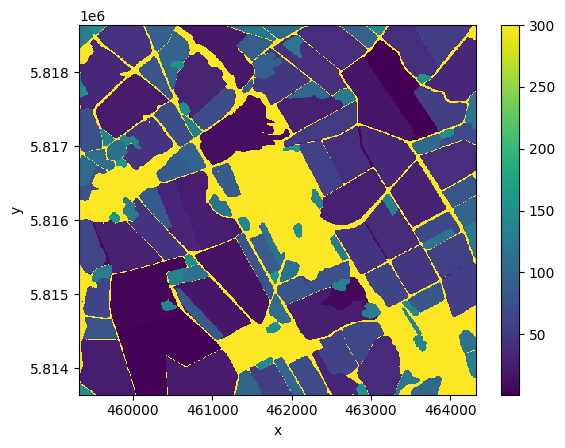

In [89]:
# Visualization of the original overlapped masks
# it will be used to create the background masks
clustered_selection_img_da.plot()

From the raw output above, create the background boolean mask:

In [91]:
# Boolean background mask 300 is equivalent to 'NaN'
bkg = np.where(clusters_selection_img == 300, False, True)

In [92]:
# Convert into xarray to get the coordinates back from the original subset (rgb_da)
bkg_img_da = xr.DataArray(bkg,
                                dims=['y','x'],
                                coords={'x':rgb_da.coords['x'],
                                        'y':rgb_da.coords['y']})
bkg_img_da = bkg_img_da.chunk({'x': 'auto', 'y': 'auto'}).astype(int)

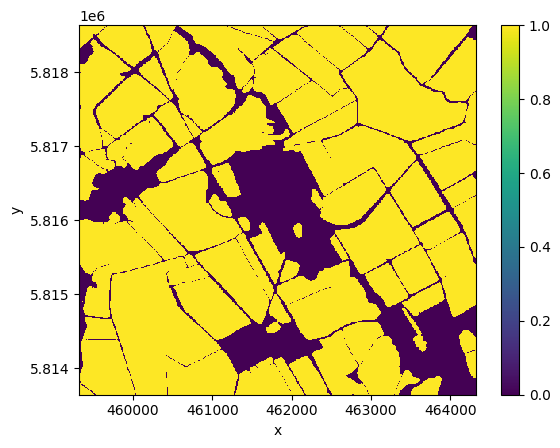

In [93]:
# Visualization of the background mask
# Purple is the background (0)
bkg_img_da.plot()

## Create Shapefile of the 100% overlap free masks for labelling

In [ ]:
t0 = time.time()
### Write segments to shapefile
write_shapefile(one_unique_mask_img_da, ds_time_stack, bkg_img_da)
print("Shapefile write done in %0.3fs." % (time.time() - t0))

# NEXT WORK STEP

To discuss:
*   Create a dataframe with row pixel and label according to mask (next week goal?)
*   Add label according to LUCAS lable (crop vs no crop) or yield crop
*   Add NDVI and other feature engineered information for data preparation
*   Use NDVI RGB image for segmentation instead of regular RGB
*   Add cloud mask
*   Add water mask